In [89]:
import numpy as np
import matplotlib.pyplot as plt

In [90]:
#The state space is 1-dimensional.
N=100 #number of states.
A=2
q_low=0.51 #probability of success of action a_low, prob. of decreasing the size of the queue.
q_high=0.6 #probab ility of success of action a_high, prob. of decreasing the size of the queue.
p=0.5 #probability that the queue increases by 1.
actions=[0,1]
def reward(x,a):
    if a==1:
        return -(x/N)**2-0.05
    return -(x/N)**2

gamma=0.99

Exclusive parameters of Homework 3

In [91]:
T=10**5
K=100
M=100

In [92]:
def piece_linear_map(x):
    function=np.zeros(int(2*N/5))
    for i in range(int(len(function)/2)):
        if 5*i<= x and x <= 5*(i+1)-1:
            function[i]=1
            break
    function[int(i+N/5)]=(x-5*i)/5
    return function

mapp_piece=np.zeros((int(2*N/5),N))
for x in range(N):
    mapp_piece[:,x]=piece_linear_map(x)

In [93]:
#We are going to build the transition matrix
#P[x,y,a] gives the probability of moving from state x to state y when taking action a.
#We will consider x-x_{t+1}; y-x_{t}; a, the action.
q_s=[q_low,q_high]
P = np.zeros((N,N,A))
for a in range(A):
    P[0,1,a]=p*(1-q_s[a])
    P[0,0,a]=p*q_s[a] + (1-p)*(1-q_s[a])+(1-p)*q_s[a]
    for x in range(1,N-1):
        P[x,x+1,a]=p*(1-q_s[a])
        P[x,x,a]=p*q_s[a] + (1-p)*(1-q_s[a])
        P[x,x-1,a]=(1-p)*q_s[a]
    P[N-1,N-1,a]=p*q_s[a] + (1-p)*(1-q_s[a])+p*(1-q_s[a])
    P[N-1,N-2,a]=(1-p)*q_s[a]

Here we define the pi function that we are going to use as a first iteration in the Soft Policy Iteration algorithm.

In [140]:
pi_initial = np.zeros((N,2))
for x in range(N):
    pi_initial[x,0]=1/2
    pi_initial[x,1]=1/2

In [141]:
pi_initial

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5,

We include the LSTD algorithm which we will use as a subroutine in the Soft Policy Iteration algorithm to compute the value function at each iteration.

In [97]:
def LSTD(mapp, samples):
    num_features = len(mapp)
    A = np.zeros((num_features, num_features))
    b = np.zeros(num_features)

    for t in range(len(samples)):
        phi_t = mapp[:, int(samples[t, 0])]
        phi_t_next = mapp[:, int(samples[t, 3])]
        reward_t = samples[t, 2]

        A += np.outer(phi_t, phi_t - gamma*phi_t_next)
        b += phi_t * reward_t
    theta = np.matmul(np.linalg.pinv(A/len(samples)), b/len(samples))

    Value = np.dot(theta, mapp)

    return Value

We will also have to generate samples for each policy generated during the Soft Policy Iteration algorithm.

In [98]:
def sample_generator(policy,X):#we will begin with 99 in the sampling for the initial policy evaluation,
    #but after that we shall input as X the last X of the trajectory of the previous policy.
    samples=np.zeros((T,4))
    for i in range(T):
        samples[i][0]=X
        #print(np.argmax(policy[X,:]))
        samples[i][1]=np.random.choice([0,1],p=policy[X,:])
        #print(samples[i][1])
        #samples[i][1]=q_s[action]
        samples[i][2]=reward(X,samples[i][1])#reward given to agent after executing the action a being in state X.
        state_trans_x=P[X,:,int(samples[i][1])]#this line gives the probabilities of transition from the state x to every other state having taken action samples[i][2].
        #next_state = np.random.choice(np.nonzero(state_trans_x)[0],p=state_trans_x[(np.nonzero(state_trans_x)[0])])
        next_state = np.random.choice(list(range(100)),p=state_trans_x)
        X=next_state
        samples[i][3]=X
    return samples

Here, we include the Q^ function which we will use to compute the next policy in the Soft Policy Iteration.

In [99]:
def Q(x,a,Value):
    if x==0:
        return reward(x,a)+ gamma*(1-p)*(1-q_s[a])*Value[int(x)]+gamma*p*(q_s[a]*Value[int(x)]+(1-q_s[a])*Value[int(x+1)])
    elif x==N-1:
        return reward(x,a) + gamma*(1-p)*(q_s[a]*Value[int(x-1)]+(1-q_s[a])*Value[int(x)])+gamma*p*q_s[a]*Value[int(x)]
    return reward(x,a) + gamma*(1-p)*(q_s[a]*Value[int(x-1)]+(1-q_s[a])*Value[int(x)])+gamma*p*(q_s[a]*Value[int(x)]+(1-q_s[a])*Value[int(x+1)])

In [142]:
def soft_policy_it(ita):
    pi=pi_initial.copy()
    samples=sample_generator(pi_initial,99)
    #print(samples[:,1])
    suma=0
    for i in range(K):
        value=LSTD(mapp_piece,samples)
        suma+=np.sum(samples[:,2])
        for x in range(N):
            valores=np.zeros(2)
            copia_pi=np.zeros(2)
            for a in actions:
                valores[a] = Q(x,a,value)
            copia_pi=np.multiply(pi[x],np.exp(ita*(valores-np.max(valores))))/(np.sum(np.multiply(pi[x],np.exp(ita*(valores-np.max(valores))))))
            pi[x,:]=0
            pi[x]=copia_pi
            #print(pi)
        #transition=trans(P,pi)
        X=int(samples[-1][0])
        samples=sample_generator(pi,X)
    print(suma)
    return pi,suma

In [144]:
from multiprocess import Pool
import os
itas=np.logspace(-2,2,30)
with Pool(processes=os.cpu_count()) as pool:
    results_list = pool.map(soft_policy_it, itas)

-285726.3345000001
-284683.86919999996
-282717.06620000006
-286026.8941-281210.4204

-271624.28720000014
-275802.6932000001
-283869.67880000017
-278936.00310000003
-285263.00269999995
-259663.03299999997
-268501.8550000001
-263343.9592
-280648.44460000005
-269773.1192000002
-321198.12600000005
-294527.6312
-260578.78280000007
-335210.2716999999
-309956.6499999999
-326947.3852000001
-323441.9194
-320393.3463
-316562.43620000005
-326024.59760000027
-330155.0150999999
-318394.0366000001
-326689.6399000001
-329702.76660000015
-325070.5034


In [146]:
results_list_rew=[i for policy,i in results_list]

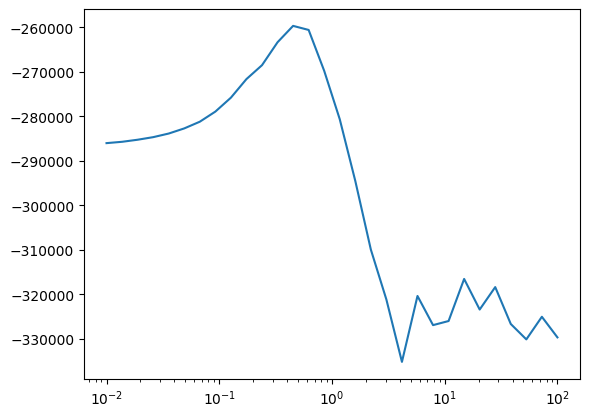

In [147]:
plt.semilogx(np.logspace(-2,2,30),results_list_rew)

As we can see, the value of ita that maximizes the total reward accumulated during the Soft Policy Algorithm is around 0.7. We can also observ that for values of ita around 1.2-1.3 and on, the performance is very poor and the total accumulated reward is very negative. Moreover, the graph is erratic in that region, showing a non uniform behaviour, i.e., for small changes in ita, the total accumulated reward changes in a big amount. It is basically due to the fact that our method involves operation with the exponential, that for big values of ita, behaves too drastically and overshoots the resulting policies in each iteration of the algorithm, ledding to a different performance of the policy according to the parameter, even if the change is small.